Karta Kusuma

Sumber Dataset: https://www.kaggle.com/datasets/greegtitan/indonesia-climate

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('climate_data.csv')
df

,date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,station_id
0,01-01-2010,21.4,30.2,27.1,82.0,9.0,0.5,7.0,90.0,5.0,E,96001
1,02-01-2010,21.0,29.6,25.7,95.0,24.0,0.2,6.0,90.0,4.0,E,96001
2,03-01-2010,20.2,26.8,24.5,98.0,63.0,0.0,5.0,90.0,4.0,E,96001
3,04-01-2010,21.0,29.2,25.8,90.0,0.0,0.1,4.0,225.0,3.0,SW,96001
4,05-01-2010,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,NaN,96001
...,...,...,...,...,...,...,...,...,...,...,...,...
589260,27-12-2020,25.2,31.2,29.2,74.0,0.0,1.4,4.0,280.0,2.0,C,97980
589261,28-12-2020,25.3,31.6,28.1,78.0,NaN,3.0,12.0,260.0,2.0,C,97980
589262,29-12-2020,24.6,32.3,28.4,81.0,NaN,6.5,5.0,260.0,2.0,SW,97980
589263,30-12-2020,25.2,32.6,28.4,80.0,0.0,2.4,7.0,260.0,2.0,C,97980


In [26]:
df = df[['date', 'Tavg']]
df

,date,Tavg
0,01-01-2010,27.1
1,02-01-2010,25.7
2,03-01-2010,24.5
3,04-01-2010,25.8
4,05-01-2010,26.7
...,...,...
589260,27-12-2020,29.2
589261,28-12-2020,28.1
589262,29-12-2020,28.4
589263,30-12-2020,28.4


In [27]:
df.isnull().sum()

date        0
Tavg    45105
dtype: int64

In [28]:
df.fillna(df['Tavg'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589265 entries, 0 to 589264
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    589265 non-null  object 
 1   Tavg    589265 non-null  float64
dtypes: float64(1), object(1)
memory usage: 9.0+ MB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [29]:
date = df['date']
temp = df['Tavg']

Text(0, 0.5, 'Temperature')

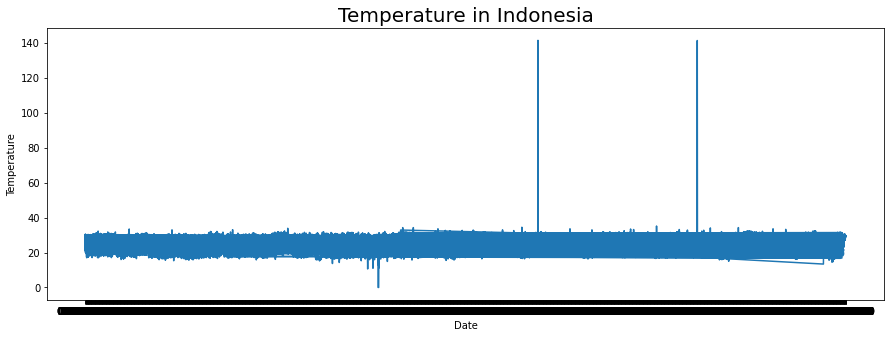

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(date, temp)
plt.title('Temperature in Indonesia', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Temperature')

In [31]:
from sklearn.model_selection import train_test_split

temp_train, temp_test, date_train, date_test = train_test_split(temp, date, test_size=0.2, random_state=0, shuffle=False)

In [32]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [33]:
wd_temp_train = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
wd_temp_test = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(
        filters=32, 
        kernel_size=5, 
        strides=1, 
        padding='causal', 
        activation='relu', 
        input_shape=[None, 1]
    ),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [35]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9),
    metrics=['mae']
)

In [36]:
val_stop = (temp.max() - temp.min()) * 0.1
val_stop

14.16

In [37]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < val_stop and logs.get('val_mae') < val_stop):
      print('\nMAE value is < 10% of data\'s scale')
      self.model.stop_training = True
callback = myCallback()

In [38]:
history = model.fit(wd_temp_train, epochs=100, validation_data=wd_temp_test, callbacks=[callback])

Epoch 1/100
   4714/Unknown - 654s 138ms/step - loss: 1.8414 - mae: 2.2183
MAE value is < 10% of data's scale
4714/4714 [==============================] - 737s 155ms/step - loss: 1.8414 - mae: 2.2183 - val_loss: 0.5457 - val_mae: 0.9360


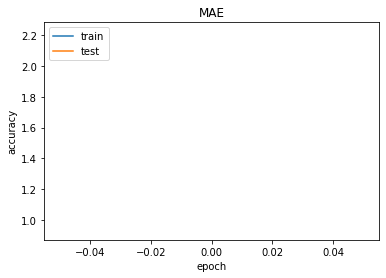

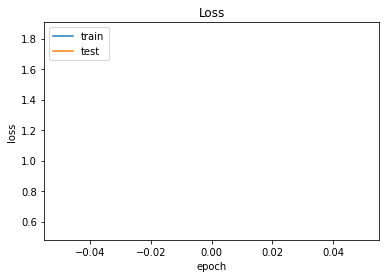

In [39]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()